# Preprocessing Data: DataFrame with Pandas

The data is split into 2 databases, true and fake news. We will first view the two databases seperately and then merge in order to split into train and test datasets. 

In [49]:
# Import dependencies
import io
import pandas as pd
import sqlalchemy
from sqlalchemy import create_engine
import re
import numpy as np
import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import tensorflow as tf 
import tensorflow.keras as keras
from tensorflow.keras.preprocessing import text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.layers.embeddings import Embedding

from collections import Counter
import seaborn as sns

from sklearn.metrics import classification_report

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [50]:
import os
spark_version = 'spark-3.3.0'
os.environ['SPARK_VERSION']=spark_version
# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [51]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("NNModel").getOrCreate()

In [53]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url ="https://s3.eu-west-2.amazonaws.com/truenewscsv/Fake.csv"
spark.sparkContext.addFile(url)
fake_df = spark.read.csv(SparkFiles.get("Fake.csv"), sep=",", header=True)
# pyspark to pandas
fake_news_df = fake_df.toPandas()

In [54]:
#  View Fake df Fake
fake_news_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


Viewing the shape and types of data.

In [55]:
fake_news_df.nunique()

title      17908
text       17453
subject      729
date        2359
dtype: int64

In [62]:
#fake_news_df['subject'].value_counts()

In [9]:
url2 ="https://s3.eu-west-2.amazonaws.com/truenewscsv/True.csv"
spark.sparkContext.addFile(url2)
true_df = spark.read.csv(SparkFiles.get("True.csv"), sep=",", header=True)
# pyspark to pandas
true_news_df = true_df.toPandas()

In [58]:
#  Import and read the True.csv.
true_news_df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [59]:
true_news_df.nunique()

title      20825
text       21192
subject       94
date         799
label          1
dtype: int64

In [61]:
#true_news_df['subject'].value_counts()

Labelling the data to prepare for the supervised machine learning model.

In [63]:
# Label fake and real data 0 and 1 
true_news_df['label']=1
fake_news_df['label']=0

Merging the dataframes and dropping columns that will skew the data.

In [64]:
# Merge dfs
frames = [true_news_df, fake_news_df]
real_or_fake_df = pd.concat(frames)

# Drop subject columns as will skew the data 
real_or_fake_df=real_or_fake_df.drop(columns=['subject'],axis=1)
# Drop date column as data not needed 
real_or_fake_df=real_or_fake_df.drop(columns=['date'],axis=1)

In [65]:
real_or_fake_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44906 entries, 0 to 23488
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   44906 non-null  object
 1   text    44898 non-null  object
 2   label   44906 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


Checking for duplicates, which will again skew the data and potentially lead to an overfitted model.

In [66]:
real_or_fake_df.duplicated().sum()

5796

In [67]:
real_or_fake_df.isnull().sum()

title    0
text     8
label    0
dtype: int64

In [68]:
real_or_fake_df.drop_duplicates()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...,...
22706,The White House and The Theatrics of ‘Gun Cont...,21st Century Wire says All the world s a stage...,0
22707,Activists or Terrorists? How Media Controls an...,Randy Johnson 21st Century WireThe majority ...,0
22708,"BOILER ROOM – No Surrender, No Retreat, Heads ...",Tune in to the Alternate Current Radio Network...,0
22709,Federal Showdown Looms in Oregon After BLM Abu...,21st Century Wire says A new front has just op...,0


In [69]:
real_or_fake_df.head()

,title,text,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1


In [70]:
real_or_fake_df.groupby('label').describe()

title                                                                 \
       count unique                                                top freq   
label                                                                         
0      23489  17908  MEDIA IGNORES Time That Bill Clinton FIRED His...    6   
1      21417  20825  Factbox: Trump fills top jobs for his administ...   14   

        text                                                                 
       count unique                                                top freq  
label                                                                        
0      23481  17453                                                     626  
1      21417  21192  (Reuters) - Highlights for U.S. President Dona...    8

In [71]:
# Finding titles that have https
URLS = r'(https?://\S+)'
real_or_fake_df['urlcount'] = real_or_fake_df['title'].apply(lambda x: re.findall(URLS, x)).str.len()

real_or_fake_df.loc[real_or_fake_df['urlcount'] > 0]

,title,text,label,urlcount
9366,https://100percentfedup.com/served-roy-moore-v...,https://100percentfedup.com/served-roy-moore-v...,0,1
15515,https://100percentfedup.com/video-hillary-aske...,https://100percentfedup.com/video-hillary-aske...,0,1
15516,https://100percentfedup.com/12-yr-old-black-co...,https://100percentfedup.com/12-yr-old-black-co...,0,1
15847,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,1
15848,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,1
17440,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,1
17441,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,1
21877,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,1
21878,https://fedup.wpengine.com/wp-content/uploads/...,https://fedup.wpengine.com/wp-content/uploads/...,0,1


In [72]:
real_or_fake_df.drop(real_or_fake_df.loc[real_or_fake_df['urlcount'] > 0].index, inplace=True)

In [73]:
real_or_fake_df['urlcount'].sum()

0

In [74]:
real_or_fake_df.columns

Index(['title', 'text', 'label', 'urlcount'], dtype='object')

In [75]:
real_or_fake_df.drop(['text', 'urlcount'], axis = 1, inplace = True)

In [76]:
real_or_fake_df.head()

,title,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


In [77]:
# Shuffle the columns randomly
real_or_fake_df = real_or_fake_df.sample(frac = 1)

# Preprocessing Data: NLP with tokenize

Tokenizing and removing stop words from the 'title' text. The totles have been broken down into tokens to enable the words and sequence in which they occur to be analysed. In this notebook we have tokenized the 'title' using the spaces in between words. 

Stop words are removed to reduce the noise and dimension of dataset. 

This notebook has used NLTK and keras to tokenize the dataset. 


In [78]:
def lower_title(x):
  try:
    return x.lower()
  except Exception as e:
    print('Error in lower_title function', str(e))
    print("Error", x)
    return x

In [79]:
# Tokenization v2
def remove_stop_words(text):
    text = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))
    text = [word for word in text if word.isalpha() and not word in stop_words]
    return ' '.join(text)
    
X = real_or_fake_df.apply(lambda row: remove_stop_words(row['title']), axis=1)
y = real_or_fake_df['label']

In [80]:
# Tokenize & Sequence X
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
X = pad_sequences(sequences)

In [45]:
#from sklearn.feature_extraction.text import CountVectorizer
# Vectorize title text to numbers
#vec = CountVectorizer(stop_words='english')
#X_train = vec.fit_transform(X_train).toarray()
#X_test = vec.transform(X_test).toarray()

In [81]:
X_df = pd.DataFrame(X)
X_df

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,884,30,307,5694,1527,225,193,485
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1472,11031,6717,6718,2638,2488,135
2,0,0,0,0,0,0,0,0,0,0,...,7,12,9,2034,160,374,5695,1528,1449,940
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,140,27,311,23,14270,9385
4,0,0,0,0,0,0,0,0,0,0,...,24,1,6719,537,486,247,1742,378,1450,167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44885,0,0,0,0,0,0,0,0,0,0,...,1485,241,136,8,33,401,106,281,535,2
44886,0,0,0,0,0,0,0,0,0,0,...,197,1,2837,1778,106,13074,13075,2164,113,2
44887,0,0,0,0,0,0,0,0,0,0,...,0,0,3131,34,274,2570,309,1335,394,383
44888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,40,325,74,686,964,427


In [82]:
X_df[0].nunique()

2

In [83]:
word_index = tokenizer.word_index

In [84]:
word_index_df = pd.DataFrame.from_dict(word_index, orient='index')
word_index_df.head()

,0
trump,1
video,2
says,3
obama,4
hillary,5


In [85]:
word_index_df.sort_values(0, ascending=False).head(5)

,0
lithuanian,19773
sailing,19772
sassou,19771
armadillo,19770
stuffed,19769


In [86]:
word_index_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19773 entries, trump to lithuanian
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       19773 non-null  int64
dtypes: int64(1)
memory usage: 309.0+ KB


# Train & Test Model

In [87]:
# For v1 of tokenization 
#y = real_or_fake_df['label']
#X = text_train_test

# split into train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Naive Bayes Classifier
Multinomial Naive Bayes classifier has been used as the data is discrete. Naive Bayes is commonly applied to text classification which is why we have tried this model first.

In [88]:
# Classification Model: Naive Bayes Classifier
nb_classifier = MultinomialNB()

nb_classifier.fit(X_train, y_train)

y_pred = nb_classifier.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(score)

0.6955520902947947


# Neural Networks
Binary classifier

The Embedding layer converts sequences into arrays of word vectors and the Dense layer classifyies arrays of word vectors.

We have used the activation function sigmoid as the model is a binary classifier. 

In [89]:
max_length = 26

In [90]:
nn_model2 = Sequential() 
nn_model2.add(Embedding(19777, 8, input_length=max_length)) 
nn_model2.add(Flatten())
nn_model2.add(Dense(78, activation='relu'))
nn_model2.add(Dense(1, activation='sigmoid'))
nn_model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 26, 8)             158216    
                                                                 
 flatten_2 (Flatten)         (None, 208)               0         
                                                                 
 dense_4 (Dense)             (None, 78)                16302     
                                                                 
 dense_5 (Dense)             (None, 1)                 79        
                                                                 
Total params: 174,597
Trainable params: 174,597
Non-trainable params: 0
_________________________________________________________________


In [91]:
history2 = nn_model2.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
688/688 [==============================] - 5s 6ms/step - loss: 0.2372 - accuracy: 0.9032 - val_loss: 0.1358 - val_accuracy: 0.9460
Epoch 2/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0681 - accuracy: 0.9749 - val_loss: 0.1217 - val_accuracy: 0.9539
Epoch 3/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0263 - accuracy: 0.9926 - val_loss: 0.1461 - val_accuracy: 0.9507
Epoch 4/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0096 - accuracy: 0.9979 - val_loss: 0.1710 - val_accuracy: 0.9500
Epoch 5/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0036 - accuracy: 0.9995 - val_loss: 0.1939 - val_accuracy: 0.9482


In [45]:
model_loss, model_accuracy = nn_model2.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}") 

Loss: 0.1700923591852188, Accuracy: 0.9500259757041931


# Model Optimization

In [92]:
# Neural Networks Model  - binary classifier
# Create the model 
nn_model = Sequential() 
nn_model.add(Embedding(19777, 8, input_length=max_length)) 
nn_model.add(Flatten())
nn_model.add(Dense(52, activation='relu'))
nn_model.add(Dense(1, activation='sigmoid'))
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 26, 8)             158216    
                                                                 
 flatten_3 (Flatten)         (None, 208)               0         
                                                                 
 dense_6 (Dense)             (None, 52)                10868     
                                                                 
 dense_7 (Dense)             (None, 1)                 53        
                                                                 
Total params: 169,137
Trainable params: 169,137
Non-trainable params: 0
_________________________________________________________________


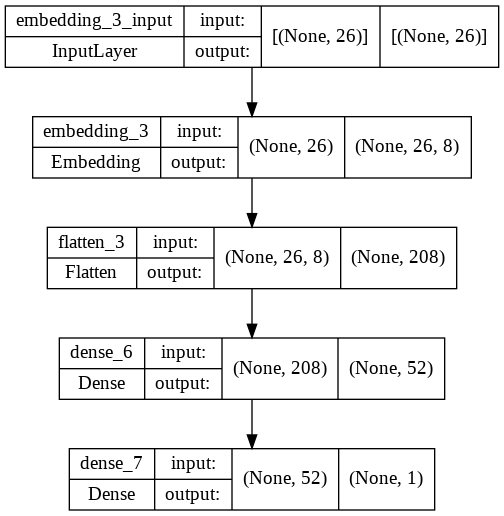

In [93]:
keras.utils.plot_model(nn_model, "nn_optimized.png", show_shapes=True)

In [94]:
# Train the model 
history = nn_model.fit(X_train, y_train, validation_split=0.3, epochs=5, batch_size=32)

Epoch 1/5
688/688 [==============================] - 4s 5ms/step - loss: 0.2451 - accuracy: 0.9018 - val_loss: 0.1261 - val_accuracy: 0.9502
Epoch 2/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0754 - accuracy: 0.9719 - val_loss: 0.1205 - val_accuracy: 0.9540
Epoch 3/5
688/688 [==============================] - 4s 5ms/step - loss: 0.0337 - accuracy: 0.9892 - val_loss: 0.1386 - val_accuracy: 0.9552
Epoch 4/5
688/688 [==============================] - 4s 6ms/step - loss: 0.0147 - accuracy: 0.9963 - val_loss: 0.1669 - val_accuracy: 0.9509
Epoch 5/5
688/688 [==============================] - 4s 5ms/step - loss: 0.0060 - accuracy: 0.9988 - val_loss: 0.1838 - val_accuracy: 0.9509


# Model Evaluation

In [95]:
# Evaluate the model using the test data
y_pred2 = nn_model.predict(X_test)

model_loss, model_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}") 

Loss: 0.19784285128116608, Accuracy: 0.9468330144882202


[]

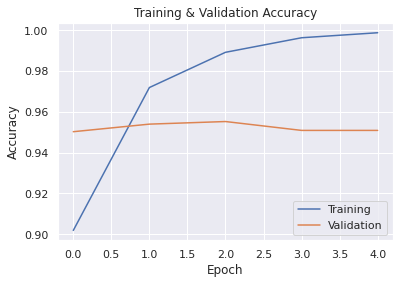

In [96]:
%matplotlib inline
sns.set()

acc = history.history['accuracy']
val = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, '-', label='Training')
plt.plot(val, '-', label='Validation')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

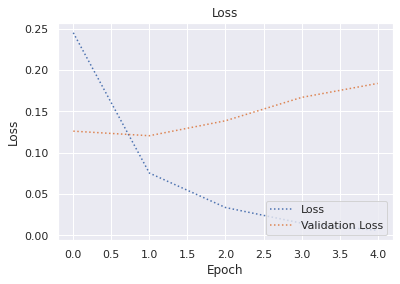

In [97]:
plt.plot(loss, ':', label='Loss')
plt.plot(val_loss, ':', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.plot()

The Loss plot shows a good leaning rate. The vallidation loss starts increase slighlty after the first epoch but still remains low. The low loss rate and high accuracy rate in addition to the slight increase in the validation loss suggests that model might potentially be over-fitting on the training data.

# Model Testing
We wanted to see if our model would work on unseen brand new data. We found two article headlines from recent weeks:

TRUE
'China Signals Missile Launch Over Taiwan' from USNEWS (3 Aug, 2022)

FAKE
''All of this without even discussing the millions of fraudulent votes that were cast or altered!' Tweet by Trump [Twitter] (Jan 01, 2021). 

In [98]:
# True News: Clean, tokenize, sequence & predict
true_test_lower = lower_title('China Signals Missile Launch Over Taiwan')
true_test_clean = remove_stop_words(true_test_lower)
sequence = tokenizer.texts_to_sequences([true_test_clean])
padded_sequence = pad_sequences(sequence, maxlen=26)
nn_model.predict(padded_sequence)[0][0]

0.9997772

In [106]:
# Fake News: Clean, tokenize, sequence & predict
fake_test_lower = lower_title('All of this without even discussing the millions of fraudulent votes that were cast or altered!')
fake_test_clean = remove_stop_words(fake_test_lower)
sequence = tokenizer.texts_to_sequences([fake_test_clean])
padded_sequence2 = pad_sequences(sequence, maxlen=26)
nn_model.predict(padded_sequence2)[0][0]

0.036136717

The model predicts that this qoute from Trump is false. This quote is indeed false which shows that our model works. 

Variations of this text was repeated by Trump 76 times. The implications for democracy is explicit. With this qoute in addition to Trump's insistence that the election was rigged, and the dozens of lawsuits, aims to undermine the democratic process and intensify the emotions of Trump's followers. 

Indeed, this claim directly led to a mob of Trump supporters storming the Capitol on Jan. 6 while formal certification of Biden’s victory was underway (Washington Post, 2022).

Similar actions by past leaders has lead to dire consequences on citizens of nations, world conflicts, and deep mistrust in the democratic process. 